# Early-Game Feature Importance for Predicting Victory

**Objective:** Identify which early-game features (at 10 minutes) are most predictive of game outcome (`blueWins`) in League of Legends Diamond-ranked games.

**What we'll do:**
1. Load the dataset and validate
2. Correlation analysis with `blueWins`
3. Train/test split
4. Logistic Regression coefficients (scaled features)
5. Random Forest feature importance
6. SHAP values for interpretability (tree-based model)

**Dataset:** `high_diamond_ranked_10min.csv`

In [1]:
# === 0. Setup ===
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



In [2]:
# === 1. Load data ===
DATA_PATH = "high_diamond_ranked_10min.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())

Shape: (9879, 40)


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:

assert "blueWins" in df.columns, "Expected 'blueWins' column."
y = df["blueWins"]


X = df.drop(columns=["blueWins"])


X = X.select_dtypes(include=[np.number])

print("Features shape:", X.shape)

Features shape: (9879, 39)


## 3. Correlation Analysis with blueWins

Top 15 features correlated with blueWins:


redGoldDiff           -0.511119
blueGoldDiff           0.511119
redExperienceDiff     -0.489558
blueExperienceDiff     0.489558
blueTotalGold          0.417213
blueGoldPerMin         0.417213
redTotalGold          -0.411396
redGoldPerMin         -0.411396
blueTotalExperience    0.396141
redTotalExperience    -0.387588
blueAvgLevel           0.357820
redAvgLevel           -0.352127
redKills              -0.339297
blueDeaths            -0.339297
redDeaths              0.337358
Name: blueWins, dtype: float64

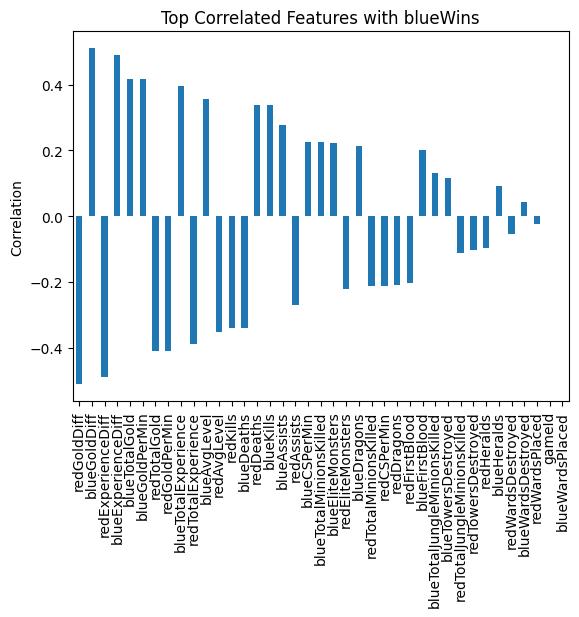

In [4]:
corr = df.corr(numeric_only=True)["blueWins"].drop("blueWins").sort_values(key=abs, ascending=False)
print("Top 15 features correlated with blueWins:")
display(corr.head(15))

plt.figure()
corr.plot(kind="bar")
plt.title("Top Correlated Features with blueWins")
plt.ylabel("Correlation")
plt.xticks(rotation=90)
plt.show()

## 4. Train/Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 5. Logistic Regression Feature Importance

Top 15 Logistic Regression Coefficients:


redGoldDiff                   -0.285838
blueGoldDiff                   0.285838
blueGoldPerMin                 0.237571
blueTotalGold                  0.237571
redTotalGold                  -0.223842
redGoldPerMin                 -0.223842
redTotalExperience            -0.194797
redExperienceDiff             -0.138327
blueExperienceDiff             0.138327
blueDragons                    0.113220
redDragons                    -0.104508
redTowersDestroyed             0.087099
redTotalJungleMinionsKilled    0.083507
redAssists                     0.082010
redEliteMonsters              -0.070435
dtype: float64

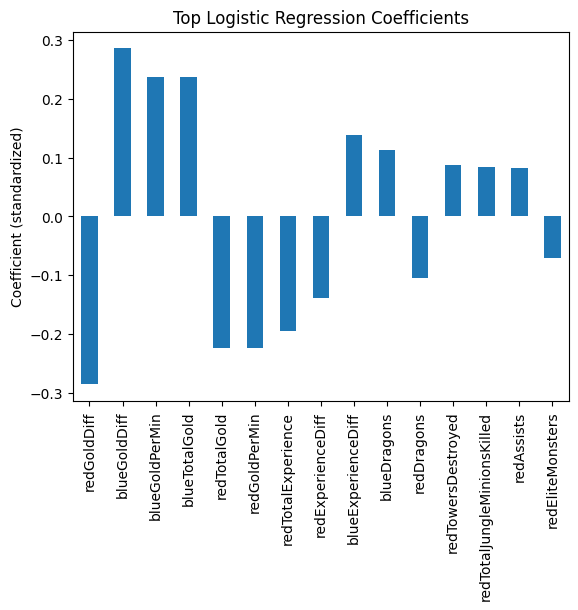

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_scaled, y_train)

log_coef = pd.Series(log_reg.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
print("Top 15 Logistic Regression Coefficients:")
display(log_coef.head(15))

plt.figure()
log_coef.head(15).plot(kind="bar")
plt.title("Top Logistic Regression Coefficients")
plt.ylabel("Coefficient (standardized)")
plt.xticks(rotation=90)
plt.show()

## 6. Random Forest Feature Importance

Top 15 Random Forest Importances:


blueGoldDiff                    0.084831
redGoldDiff                     0.083246
blueExperienceDiff              0.067940
redExperienceDiff               0.065515
blueTotalGold                   0.048079
blueGoldPerMin                  0.042997
redGoldPerMin                   0.042547
redTotalGold                    0.040915
redTotalExperience              0.040674
blueTotalExperience             0.037118
gameId                          0.033887
redCSPerMin                     0.026694
blueCSPerMin                    0.026572
blueTotalJungleMinionsKilled    0.026484
blueTotalMinionsKilled          0.026166
dtype: float64

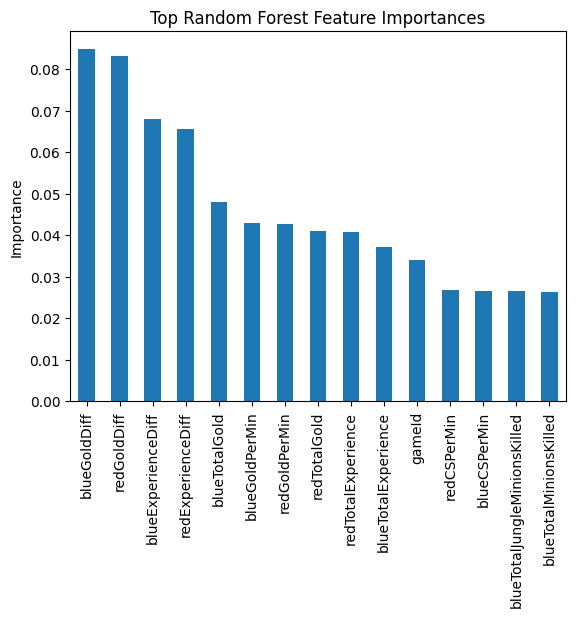

In [7]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 15 Random Forest Importances:")
display(rf_importances.head(15))

plt.figure()
rf_importances.head(15).plot(kind="bar")
plt.title("Top Random Forest Feature Importances")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()

## 7. SHAP Analysis for Interpretability

In [8]:
try:
    import shap
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_test)

    print("Generating SHAP summary plot...")
    shap.summary_plot(shap_values[1], X_test, plot_type="bar")
except ImportError:
    print("SHAP not installed. Run: pip install shap")

Generating SHAP summary plot...


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

### Notes:
- Correlation is univariate; feature importance from models is multivariate (accounts for interactions).
- SHAP provides the most interpretable view of how features contribute to predictions.